In [31]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
import torch.nn as nn

df1 = pd.read_csv("archive/AABA_2006-01-01_to_2018-01-01.csv")[["Date","Close"]]
df2 = pd.read_csv("archive/AAPL_2006-01-01_to_2018-01-01.csv")[["Date","Close"]]
pd.to_datetime(df1["Date"])
df1.head()

,Date,Close
0,2006-01-03,40.91
1,2006-01-04,40.97
2,2006-01-05,41.53
3,2006-01-06,43.21
4,2006-01-09,43.42


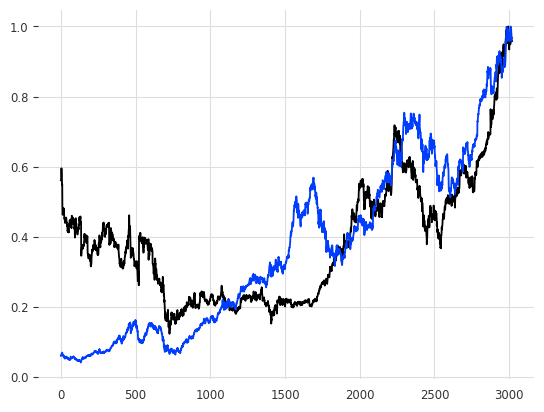

In [3]:
fig, ax = plt.subplots()
ax.plot(df1.index,df1["Close"]/df1["Close"].max())
ax.plot(df2.index,df2["Close"]/df2["Close"].max())

# LSTM

This is a LSTM model.

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [5]:
from copy import deepcopy as dc #?


def prepare_df_for_lstm(df,n_steps):
    df = dc(df)
    df.set_index("Date", inplace = True)

    for i in range(1,n_steps+1):
        df[f"Close(t-{i})"] = df["Close"].shift(i)

    df.dropna(inplace = True)

    return df

lookback = 7
shifted_df1 = prepare_df_for_lstm(df1, lookback)
shifted_df1

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2006-01-12,40.89,41.87,42.98,43.42,43.21,41.53,40.97,40.91
2006-01-13,39.90,40.89,41.87,42.98,43.42,43.21,41.53,40.97
2006-01-17,40.11,39.90,40.89,41.87,42.98,43.42,43.21,41.53
2006-01-18,35.18,40.11,39.90,40.89,41.87,42.98,43.42,43.21
2006-01-19,34.33,35.18,40.11,39.90,40.89,41.87,42.98,43.42
...,...,...,...,...,...,...,...,...
2017-12-22,71.58,71.59,70.90,70.21,70.14,70.29,69.23,71.24
2017-12-26,69.86,71.58,71.59,70.90,70.21,70.14,70.29,69.23
2017-12-27,70.06,69.86,71.58,71.59,70.90,70.21,70.14,70.29


In [6]:
shifted_df1_as_np = shifted_df1.to_numpy()
shifted_df1_as_np

array([[40.89, 41.87, 42.98, ..., 41.53, 40.97, 40.91],
       [39.9 , 40.89, 41.87, ..., 43.21, 41.53, 40.97],
       [40.11, 39.9 , 40.89, ..., 43.42, 43.21, 41.53],
       ...,
       [70.06, 69.86, 71.58, ..., 70.21, 70.14, 70.29],
       [69.82, 70.06, 69.86, ..., 70.9 , 70.21, 70.14],
       [69.85, 69.82, 70.06, ..., 71.59, 70.9 , 70.21]])

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (-1,1))
shifted_df1_as_np = scaler.fit_transform(shifted_df1_as_np)

shifted_df1_as_np

array([[-1.56298843e-03,  2.90715849e-02,  6.37699281e-02, ...,
         1.84432635e-02,  9.37793060e-04, -9.37793060e-04],
       [-3.25101594e-02, -1.56298843e-03,  2.90715849e-02, ...,
         7.09596749e-02,  1.84432635e-02,  9.37793060e-04],
       [-2.59456080e-02, -3.25101594e-02, -1.56298843e-03, ...,
         7.75242263e-02,  7.09596749e-02,  1.84432635e-02],
       ...,
       [ 9.10284464e-01,  9.04032510e-01,  9.57799312e-01, ...,
         9.14973429e-01,  9.12785245e-01,  9.17474211e-01],
       [ 9.02782119e-01,  9.10284464e-01,  9.04032510e-01, ...,
         9.36542670e-01,  9.14973429e-01,  9.12785245e-01],
       [ 9.03719912e-01,  9.02782119e-01,  9.10284464e-01, ...,
         9.58111910e-01,  9.36542670e-01,  9.14973429e-01]])

In [8]:
X = shifted_df1_as_np[:,1:]
X = dc(np.flip(X, axis = 1))
y = shifted_df1_as_np[:,0]

X.shape, y.shape

((3012, 7), (3012,))

In [9]:
split_index = int(len(X)*0.95)
split_index

2861

In [10]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2861, 7), (151, 7), (2861,), (151,))

In [11]:
X_train = X_train.reshape((-1,lookback,1)) 
X_test = X_test.reshape((-1,lookback,1))
y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2861, 7, 1), (151, 7, 1), (2861, 1), (151, 1))

In [12]:
X_train = torch.tensor(X_train).float()
X_test  = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test  = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([2861, 7, 1]),
 torch.Size([151, 7, 1]),
 torch.Size([2861, 1]),
 torch.Size([151, 1]))

In [13]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [14]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
for _,batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [16]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [17]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [18]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [19]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1


Batch 100, Loss: 0.133

Val Loss: 1.283
***************************************************

Epoch: 2
Batch 100, Loss: 0.104

Val Loss: 1.026
***************************************************

Epoch: 3
Batch 100, Loss: 0.063

Val Loss: 0.209
***************************************************

Epoch: 4
Batch 100, Loss: 0.002

Val Loss: 0.202
***************************************************

Epoch: 5
Batch 100, Loss: 0.001

Val Loss: 0.162
***************************************************

Epoch: 6
Batch 100, Loss: 0.001

Val Loss: 0.151
***************************************************

Epoch: 7
Batch 100, Loss: 0.001

Val Loss: 0.146
***************************************************

Epoch: 8
Batch 100, Loss: 0.001

Val Loss: 0.141
***************************************************

Epoch: 9
Batch 100, Loss: 0.001

Val Loss: 0.138
***************************************************

Epoch: 10
Batch 100, Loss: 0.001

Val Loss: 0.134
*****************************************

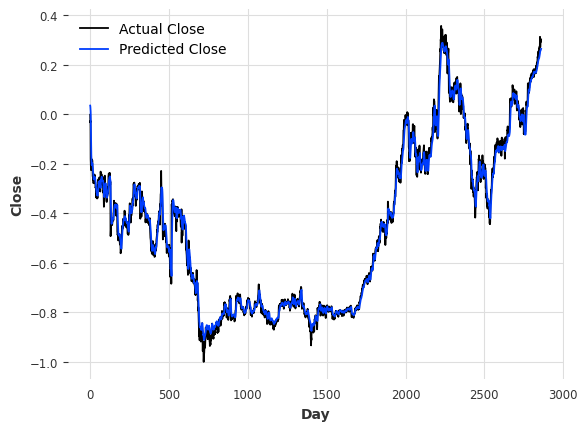

In [20]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [21]:
shifted_df_2 = prepare_df_for_lstm(df2, lookback)
shifted_df_2_as_np = shifted_df_2.to_numpy()
shifted_df_2_as_np = scaler.fit_transform(shifted_df_2_as_np)

X_2 = shifted_df_2_as_np[:,1:]
X_2 = dc(np.flip(X_2, axis = 1))
y_2 = shifted_df_2_as_np[:,0]

X_train_2 = X_2[:split_index]
X_test_2 = X_2[split_index:]

y_train_2 = y_2[:split_index]
y_test_2 = y_2[split_index:]

X_train_2 = X_train_2.reshape((-1,lookback,1)) 
X_test_2 = X_test_2.reshape((-1,lookback,1))
y_train_2 = y_train_2.reshape((-1,1))
y_test_2 = y_test_2.reshape((-1,1))

X_train_2 = torch.tensor(X_train_2).float()
X_test_2  = torch.tensor(X_test_2).float()
y_train_2 = torch.tensor(y_train_2).float()
y_test_2  = torch.tensor(y_test_2).float()

In [22]:
with torch.no_grad():
    predicted_2 = model(X_train_2.to(device)).to('cpu').numpy()

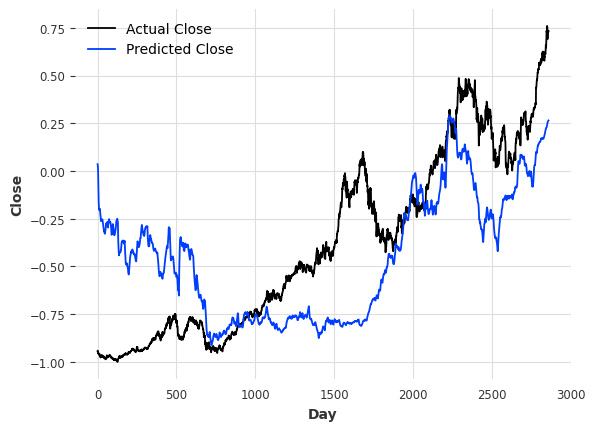

In [23]:
plt.plot(y_train_2, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

# N-BEATS

In [90]:
from darts import TimeSeries

df1 = pd.read_csv("archive/AABA_2006-01-01_to_2018-01-01.csv")[:100]
df2 = pd.read_csv("archive/AAPL_2006-01-01_to_2018-01-01.csv")[:100]
df1["Index"] = df1.index 
df2["Index"] = df2.index 

df1["Close"] = df1["Close"]/df1["Close"].max() 
df2["Close"] = df2["Close"]/df2["Close"].max()

<Axes: xlabel='Index'>

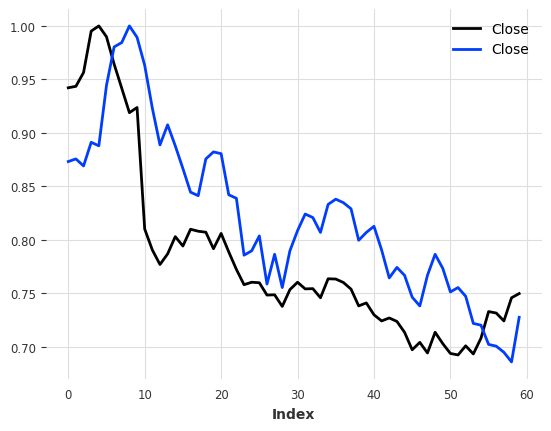

In [91]:

series_1 = TimeSeries.from_dataframe(df1, time_col="Index",value_cols="Close")
series_2 = TimeSeries.from_dataframe(df2, time_col="Index", value_cols="Close")

train_1, val_1 = series_1[:60], series_1[60:]
train_2, val_2 = series_2[:60], series_2[60:]

#plt.plot(train_2,label="component")
train_1.plot()
train_2.plot()

In [92]:
from darts.models import NBEATSModel


model_multi_series = NBEATSModel(input_chunk_length=24, output_chunk_length=12)
model_multi_series.fit([train_1,train_2])


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


NBEATSModel(generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12)

In [93]:

pred_1 = model_multi_series.predict(n=40, series=train_1)
pred_2 = model_multi_series.predict(n=40, series=train_2)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

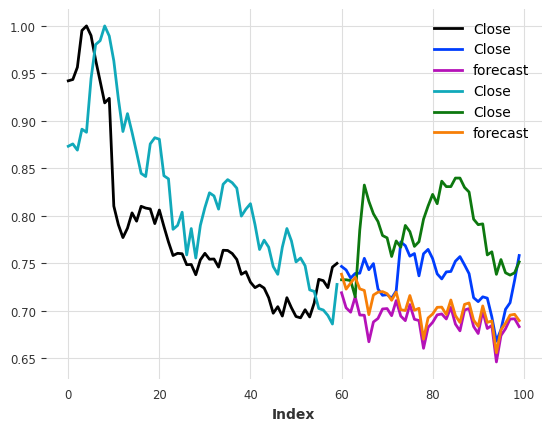

In [94]:

train_1.plot()
val_1.plot()
pred_1.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)

train_2.plot()
val_2.plot()
pred_2.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)

#plt.plot(df1.iloc[].index,df1.iloc[]["Close"])
plt.legend()